# Transfer Learning

Inspired by: https://github.com/openai/openai-cookbook/blob/main/examples/Customizing_embeddings.ipynb

In [1]:
# imports

from typing import List, Tuple  # for type hints

import numpy as np  # for manipulating arrays
import pandas as pd  # for manipulating data in dataframes
import plotly.express as px  # for plots
import random  # for generating run IDs
from sklearn.model_selection import train_test_split  # for splitting train & test data
import torch  # for matrix optimization
import torch.nn as nn 
import torch.nn.functional as F
import torchmetrics
import os
import datasets
from livelossplot import PlotLosses
from sentence_transformers.util import pairwise_angle_sim

from mteb import MTEB

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## 1. Load and process input data

In [3]:
def load_dataset_for_task(task_name: str):
    # Note, we load all splits except the test set
    mteb = MTEB(tasks=[task_name], task_langs=["en"])
    task = mteb.tasks[0]
    task.load_data()
    assert task.data_loaded, "Data was not loaded"
    lis_dfs = []
    for split in task.dataset:
        if split == 'test':
            continue
        print(f"Split: {split}")
        lis_dfs.append(task.dataset[split].to_pandas())
    return pd.concat(lis_dfs)

def process_dataset(train_df: datasets.Dataset) -> pd.DataFrame:
    train_df = train_df[['sentence1', 'sentence2', 'score']]
    def normalize(x, min_score, max_score): # Norm between 0 and 1
        zero_one = (x - min_score) / (max_score - min_score)
        scaled_down = zero_one 
        return scaled_down 
    train_df['score'] = normalize(train_df['score'], train_df['score'].min(), train_df['score'].max())
    return train_df

In [4]:
TASKS = [ # Only ones with train or val data 
    "STS12",
    "STSBenchmark",
]

dfs = {}
for task_name in TASKS:
    print("Loading task:", task_name)
    dataset_df = load_dataset_for_task(task_name)
    df_task = process_dataset(dataset_df)
    dfs[task_name] = df_task



Loading task: STS12
Split: train
Loading task: STSBenchmark


/tmp/ipykernel_331879/3342176186.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['score'] = normalize(train_df['score'], train_df['score'].min(), train_df['score'].max())


Split: train
Split: validation


/tmp/ipykernel_331879/3342176186.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['score'] = normalize(train_df['score'], train_df['score'].min(), train_df['score'].max())


## 2. Generate Synthetic Data

In [5]:
# TODO (Look at generating for dissimilar data cause all of them seem to be similar)

## 3. Get Embeddings and Cosine Similarities

In [6]:
from model_factory import model_factory
model_name = 'angle$cohere$flag-embedding$gist$gte-large$llmrails$mixed-bread$voyage'

In [7]:
def generate_embedding(df: pd.DataFrame, model_name: str, task_name: str):
    model = model_factory(model_name, task_name)
    for column in ['sentence1', 'sentence2']:
        df[f"{column}_embedding"] = model.encode(df[column].tolist())

def get_cosine_similarity(a: np.array, b: np.array):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

def generate_cosine_similarity(df: pd.DataFrame):
    df['cosine_similarity'] = df.apply(lambda x: get_cosine_similarity(x['sentence1_embedding'], x['sentence2_embedding']), axis=1)

In [8]:
for task_name, df in dfs.items():
    generate_embedding(df, model_name, task_name)
    generate_cosine_similarity(df)


Creating model angle$cohere$flag-embedding$gist$gte-large$llmrails$mixed-bread$voyage for task STS12
Loading angle from cache for STS12...
Loading cohere from cache for STS12...
Loading flag-embedding from cache for STS12...
Loading gist from cache for STS12...
Loading gte-large from cache for STS12...
Loading llmrails from cache for STS12...
Loading mixed-bread from cache for STS12...
Loading voyage from cache for STS12...
Creating model angle$cohere$flag-embedding$gist$gte-large$llmrails$mixed-bread$voyage for task STSBenchmark
Loading angle from cache for STSBenchmark...
Loading cohere from cache for STSBenchmark...
Loading flag-embedding from cache for STSBenchmark...
Loading gist from cache for STSBenchmark...
Loading gte-large from cache for STSBenchmark...
Loading llmrails from cache for STSBenchmark...
Loading mixed-bread from cache for STSBenchmark...
Loading voyage from cache for STSBenchmark...


/tmp/ipykernel_331879/914044319.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{column}_embedding"] = model.encode(df[column].tolist())
/tmp/ipykernel_331879/914044319.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{column}_embedding"] = model.encode(df[column].tolist())
/tmp/ipykernel_331879/914044319.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [9]:
# Combine all the dataframes
df = pd.concat(dfs.values(), ignore_index=True)

# Shuffle the data
df = df.sample(frac=1, random_state=seed).reset_index(drop=True)

# Split the data
df_train, df_val = train_test_split(df, test_size=0.2, random_state=seed)

# Reset the index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

df_train

,sentence1,sentence2,score,sentence1_embedding,sentence2_embedding,cosine_similarity
0,A lawsuit has been filed in an attempt to bloc...,Supporters asked a federal court Monday to blo...,0.64,"[-0.010843591625434846, -0.005540227466296054,...","[-0.0030294301616798566, -0.000758714636002349...",0.834596
1,A group of people sitting around a table on a ...,A group of people sitting around a table with ...,0.72,"[-0.003503889882394399, 0.009956839626105695, ...","[-0.0037052550052533, -0.0035288394878853543, ...",0.804369
2,Suspected U.S. drone strike kills 5 in Pakistan,Suspected US drone targets Islamic seminary in...,0.44,"[-0.0020148544532297133, 0.00145176103426662, ...","[0.002575315346729413, -0.0021372128787824343,...",0.769520
3,Canadian Muslims issue fatwa against 'honor ki...,"US, Canadian imams issue fatwa against honour ...",0.68,"[-0.005642276376166227, -0.0010918316555994932...","[-0.009941856891099018, -0.0008553290847255954...",0.882600
4,Two girls are in pajama pants and appear to be...,Two girls with baseball caps are eating a snac...,0.12,"[0.006566920602883639, 0.03168304908753492, -0...","[-0.008607925662653095, 0.011728056263967402, ...",0.579691
...,...,...,...,...,...,...
7581,A man plays a guitar.,A man is playing a guitar.,1.00,"[0.009159515221895804, 0.005712223275963507, 0...","[0.009874405156255612, 0.007041068175604732, 0...",0.991686
7582,Australia returns asylum seekers to Sri Lanka ...,Australia: Australia hands asylum-seekers back...,0.92,"[-0.002586047319405451, 0.02023193081993265, -...","[-0.0014642671977004907, 0.012129298547162007,...",0.934523
7583,"The pill, which they call the ""polypill,"" woul...",The ingredients of such a polypill would conta...,1.00,"[-0.006024808354230715, 0.00342869814839013, 0...","[-0.007344913602651229, 0.004676949898643212, ...",0.942603
7584,Israel expands subsidies to settlements,Israel widens settlement subsidies,1.00,"[0.0010825372614498541, 0.009586470464930366, ...","[0.0039996918103350305, 0.011384037664537824, ...",0.968003


## 4. Evaluate The Baseline Performance

We use spearman and Pearson to evaluate the performance. 

Pearson correlation is a measure of strength of linear relationship between two variables. It ranges from -1 to 1.

While spearman correlation is a measure of monotonic relationship between two variables. It ranges from -1 to 1.

We want both these values to be close to 1. 


In [10]:
def get_correlation(df: pd.DataFrame, column_name: str = 'cosine_similarity'):
    return df[column_name].corr(df['score'], method='spearman'), df[column_name].corr(df['score'], method='pearson')

spearmans, pearsons = get_correlation(df_train)
print(f"Train: Spearman: {spearmans}, Pearson: {pearsons}")

spearmans, pearsons = get_correlation(df_val)
print(f"Validation: Spearman: {spearmans}, Pearson: {pearsons}")

Train: Spearman: 0.891131513624253, Pearson: 0.8984660577443869
Validation: Spearman: 0.8925307125312192, Pearson: 0.9064482181019092


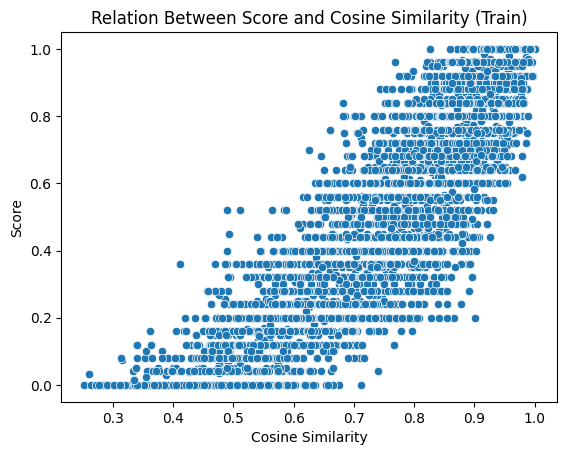

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation(df: pd.DataFrame, title: str):
    sns.scatterplot(data=df, x='cosine_similarity', y='score')
    plt.title(title)
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Score')
    plt.show()

plot_correlation(df_train, 'Relation Between Score and Cosine Similarity (Train)')

# 5. Preprocessing before training



In [12]:
def get_tensors(df):
    df_x1 = np.stack(df['sentence1_embedding'].values)
    df_x2 = np.stack(df['sentence2_embedding'].values)
    df_y = df['score'].values

    X1 = torch.from_numpy(df_x1).float()
    X2 = torch.from_numpy(df_x2).float()
    Y = torch.from_numpy(df_y).float()
    return X1, X2, Y
    
X1_train, X2_train, Y_train = get_tensors(df_train)
X1_val, X2_val, Y_val = get_tensors(df_val)

# Move everything to the device
X1_train = X1_train.to(device)
X2_train = X2_train.to(device)
Y_train = Y_train.to(device)

X1_val = X1_val.to(device)
X2_val = X2_val.to(device)
Y_val = Y_val.to(device)

# 6. Transfer Learning

Defining our Model

In [13]:
from tl_models import LinearTransformationModel, ElementwiseProductModel, StackWiseProductModel

In [14]:
class CosineSimilarityModel(torch.nn.Module):
    def __init__(self, transformation_model: torch.nn.Module):
        super(CosineSimilarityModel, self).__init__()
        self.transformation_model = transformation_model
    
    def forward(self, embeddings1: torch.Tensor, embeddings2: torch.Tensor):
        embedding1_custom = self.transformation_model(embeddings1)
        embedding2_custom = self.transformation_model(embeddings2)
        return torch.nn.functional.cosine_similarity(embedding1_custom, embedding2_custom, dim=1)

class AnglEModel(torch.nn.Module):
    def __init__(self, transformation_model: torch.nn.Module, scale: float = 20.0):
        super(AnglEModel, self).__init__()
        self.transformation_model = transformation_model
        self.scale = scale
    
    def forward(self, embeddings1: torch.Tensor, embeddings2: torch.Tensor):
        scores = pairwise_angle_sim(self.transformation_model(embeddings1), self.transformation_model(embeddings2))
        return scores


Possible Loss Functions

In [15]:
def mse_loss(cosine_similarity: torch.Tensor, scores: torch.Tensor):
    lossF = torch.nn.MSELoss()
    return lossF(cosine_similarity, scores)

def spearman_correlation(cosine_similarity: torch.Tensor, scores: torch.Tensor):
    spearman_corr = torchmetrics.SpearmanCorrCoef().to(device)
    return spearman_corr(cosine_similarity, scores)

def pearson_correlation(cosine_similarity: torch.Tensor, scores: torch.Tensor):
    pearson_corr = torchmetrics.PearsonCorrCoef().to(device)
    return pearson_corr(cosine_similarity, scores)

def angle_loss(scores: torch.Tensor, labels: torch.Tensor, scale: float = 20.0):
    scores = scores * scale
    scores = scores[:, None] - scores[None, :]

    labels = labels[:, None] < labels[None, :]
    labels = labels.float()

    scores = scores - (1 - labels) * 1e12

    scores = torch.cat((torch.zeros(1).to(device), scores.view(-1)), dim=0)
    loss = torch.logsumexp(scores, dim=0)
    return loss

Training Loop

In [16]:
def train_one_epoch(model, training_loader, optimizer, loss_function = None):
    running_loss = 0.

    for X1, X2, Y in training_loader:
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        cosine_sim = model(X1, X2)
        loss = loss_function(cosine_sim, Y)
        
        # Compute the loss and its gradients
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Record the loss
        running_loss += loss.item()

    average_loss = running_loss / len(training_loader)
    return average_loss


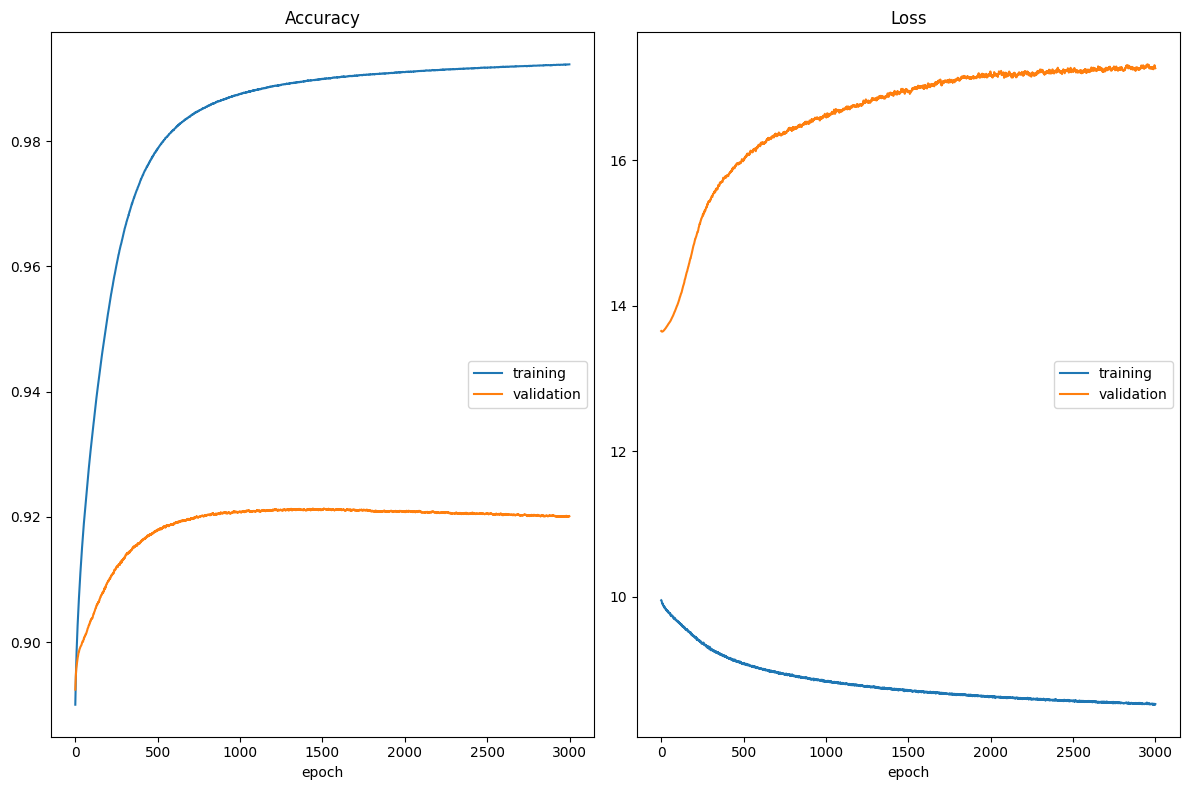

Accuracy
	training         	 (min:    0.890, max:    0.992, cur:    0.992)
	validation       	 (min:    0.892, max:    0.921, cur:    0.920)
Loss
	training         	 (min:    8.515, max:    9.951, cur:    8.524)
	validation       	 (min:   13.643, max:   17.318, cur:   17.265)


In [17]:
out_dir = 'test_results'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Hyperparameters
max_epochs = 3_000
lr = 1e-4 # 1e-5 is the smoothest
batch_size = 300
momentum = 0.9

# Loss function
# loss_function = mse_loss
loss_function = angle_loss

# Model
transformation_model = LinearTransformationModel(1024 * 8, 1024 * 8, dropout_rate=0.4)  # NOTE: dropout of 0.5 seems to work better than 0.1
# transformation_model = ElementwiseProductModel(1024 * 8)
# transformation_model = StackWiseProductModel(8)

# model = CosineSimilarityModel(transformation_model)
# model = model.to(device)

model = AnglEModel(transformation_model)
model = model.to(device)

# Optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# Data Loader
train_dataset = torch.utils.data.TensorDataset(X1_train, X2_train, Y_train)
training_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# Keep track of losses
plotlosses = PlotLosses()

model.train()
best_accuracy = 0.920 # Should be better then this
epochs_saved = []
for epoch_num in range(max_epochs):
    epoch_loss = train_one_epoch(model, training_loader, optimizer, loss_function)

    # Additional metrics for performance tracking
    model.eval()
    with torch.no_grad():
        # Generate the validation loss
        val_predictions = model(X1_val, X2_val)
        val_loss = loss_function(val_predictions, Y_val).item()

        # Compute the correlations
        train_spearman = spearman_correlation(model(X1_train, X2_train), Y_train).item()
        val_spearman = spearman_correlation(val_predictions, Y_val).item()

        # Save locally if it is the best
        if val_spearman > best_accuracy: # Only save if it does not change much
            epochs_saved.append(epoch_num)
            best_accuracy = val_spearman
            torch.save({'transformation_model': model.transformation_model}, f"{out_dir}/best_model.pth")

    model.train()

    plotlosses.update({'loss': epoch_loss, 'val_loss': val_loss, 'acc': train_spearman, 'val_acc': val_spearman})
    plotlosses.send()

torch.save({'transformation_model': model.transformation_model}, f"{out_dir}/final_model.pth")

# 7. Evaluation

In [18]:
print("Eochs saved:", epochs_saved[-10:])
print("Best accuracy:", best_accuracy)

Eochs saved: [1141, 1182, 1199, 1209, 1219, 1220, 1310, 1440, 1444, 1509]
Best accuracy: 0.9213203191757202


Load from memory

In [19]:
state_dict = torch.load(f"test_results/best_model.pth")
transformation_model = state_dict["transformation_model"].to(device)
model = AnglEModel(transformation_model)

In [20]:
model.eval()
with torch.no_grad():
    val_predictions = model(X1_val, X2_val)
    val_spearman = spearman_correlation(val_predictions, Y_val).item()
    val_pearson = pearson_correlation(val_predictions, Y_val).item()

print(f"Validation Spearman: {val_spearman:.3f}, Validation Pearson: {val_pearson:.3f}")    

Validation Spearman: 0.921, Validation Pearson: 0.930
